# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from fractions import Fraction
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn import preprocessing 
from sklearn.model_selection import LeaveOneOut, KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, LinearRegression, Ridge, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from random import shuffle, seed
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.inspection import permutation_importance

import textwrap
import warnings
warnings.simplefilter(action='ignore')

In [2]:
data = pd.read_csv('data/vehicles.csv')

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [3]:
data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [5]:
data.shape

(426880, 18)

In [6]:
data.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [7]:
data.apply(lambda col: col.unique() if col.dtype == 'object' else None).dropna() 

region          [prescott, fayetteville, florida keys, worcest...
manufacturer    [nan, gmc, chevrolet, toyota, ford, jeep, niss...
model           [nan, sierra 1500 crew cab slt, silverado 1500...
condition       [nan, good, excellent, fair, like new, new, sa...
cylinders       [nan, 8 cylinders, 6 cylinders, 4 cylinders, 5...
fuel                  [nan, gas, other, diesel, hybrid, electric]
title_status    [nan, clean, rebuilt, lien, salvage, missing, ...
transmission                      [nan, other, automatic, manual]
VIN             [nan, 3GTP1VEC4EG551563, 1GCSCSE06AZ123805, 3G...
drive                                        [nan, rwd, 4wd, fwd]
size             [nan, full-size, mid-size, compact, sub-compact]
type            [nan, pickup, truck, other, coupe, SUV, hatchb...
paint_color     [nan, white, blue, red, black, silver, grey, b...
state           [az, ar, fl, ma, nc, ny, or, pa, tx, wa, wi, a...
dtype: object

In [8]:
#Check for the number of catagorical values

print("\n  Column Name                # of Categories")
print("\n______________              _________________\n")

list(map(lambda col: print(col + "\t\t\t\t" + str(data[col].value_counts().count())) , \
         data.select_dtypes(include=['object', 'category']).columns.tolist()));


  Column Name                # of Categories

______________              _________________

region				404
manufacturer				42
model				29649
condition				6
cylinders				8
fuel				5
title_status				6
transmission				3
VIN				118246
drive				3
size				4
type				13
paint_color				12
state				51


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [9]:
# Check for duplicates

data.duplicated().sum()

0

In [10]:
# Check for missing values in percent

data.isna().mean().mul(100).round(2)

id               0.00
region           0.00
price            0.00
year             0.28
manufacturer     4.13
model            1.24
condition       40.79
cylinders       41.62
fuel             0.71
odometer         1.03
title_status     1.93
transmission     0.60
VIN             37.73
drive           30.59
size            71.77
type            21.75
paint_color     30.50
state            0.00
dtype: float64

In [11]:
# Columns that have least relevence to the car price will be dropped
# For example, becasue VIN is deemed not relevent, the column is removed.

data.drop(['id','region','VIN','size'], axis=1, inplace=True)


In [12]:
# Remaining missing values in percentage

data.isna().mean().mul(100).round(2)

price            0.00
year             0.28
manufacturer     4.13
model            1.24
condition       40.79
cylinders       41.62
fuel             0.71
odometer         1.03
title_status     1.93
transmission     0.60
drive           30.59
type            21.75
paint_color     30.50
state            0.00
dtype: float64

In [13]:
# Given the nature of the features and its the missing values will be filled using SimpleImputer with strategy =  'mean' and 'most_frequent'.

data[['year', 'odometer']] = SimpleImputer(strategy='mean').fit_transform(data[['year', 'odometer']])
data[data.columns[data.isnull().any()].tolist()] = SimpleImputer(strategy='most_frequent').fit_transform(data[data.columns[data.isnull().any()].tolist()])

In [14]:
#Now lets make sure there are no null values

data.isna().mean().mul(100).round(2)

price           0.0
year            0.0
manufacturer    0.0
model           0.0
condition       0.0
cylinders       0.0
fuel            0.0
odometer        0.0
title_status    0.0
transmission    0.0
drive           0.0
type            0.0
paint_color     0.0
state           0.0
dtype: float64

In [15]:
#Lets examine the categories under 'title_status'
item_counts = data.title_status.value_counts()
print(item_counts)

title_status
clean         413359
rebuilt         7219
salvage         3868
lien            1422
missing          814
parts only       198
Name: count, dtype: int64


In [16]:
#Since the model has a large number of categories and is compensiated by manufacturer, the 'model' column will be dropped
data.drop(['model'], axis=1, inplace=True)

In [17]:
#Lets separate classic cars below 1960 from the rest of the data. 
#Then way we will focus on the cars that have been maunfactured in 1960 and after.

classic_df = data[ ((data['year'] < 1960) & (data['price'] < 500001))][['year', 'price', 'manufacturer', 'type', 'fuel']]
expensive_classic_df = data[ ((data['year'] < 1960) & (data['price'] > 500000))][['year', 'price', 'manufacturer', 'type', 'fuel']]


In [18]:
# Lets examine and clean outliers for Price
# Lets remove outliers - 'price > 1000 & price < 75000' (per the distribution) 

indexPrice = data[ (data['price'] < 1000) | (data['price'] > 75000) ].index
data.drop(indexPrice , inplace=True)

# Examine Year of Manufacture
# Lets remove outliers - 'year >= 1960 ' (per the distribution) 

indexPrice = data[ (data['year'] < 1960)].index
data.drop(indexPrice, inplace=True)

#Convert 'year' to 'age' - to help aid in analysis

data['age'] = 2024 - data['year'].astype('int')
data.drop('year', axis=1, inplace=True)

# Examine Odometer 
# Lets remove outliers -  'odometer > 300000' (per the distribution) 

sns.set(style="darkgrid",font_scale=1.0)
indexPrice = data[ (data['odometer'] > 300000) ].index
data.drop(indexPrice , inplace=True)


In [19]:
# Lets examine the categories under 'cylinders'
item_counts = data.cylinders.value_counts().div(data.shape[0]).mul(100).round(2)
print(item_counts)

cylinders
6 cylinders     63.50
4 cylinders     18.53
8 cylinders     16.80
5 cylinders      0.43
10 cylinders     0.29
other            0.25
3 cylinders      0.15
12 cylinders     0.04
Name: count, dtype: float64


In [20]:
#Give the small number of 'other' category, associated rows will be removed
#Delete the rows with 'cylinders' == 'other'

indexCyl = data[(data['cylinders'] == 'other')].index
data.drop(indexCyl , inplace=True)

In [21]:
#Drop state given that it has little relevence to the business goal
data.drop('state', axis=1, inplace=True)

#### We are done with data cleaning

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 372616 entries, 0 to 426879
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         372616 non-null  int64  
 1   manufacturer  372616 non-null  object 
 2   condition     372616 non-null  object 
 3   cylinders     372616 non-null  object 
 4   fuel          372616 non-null  object 
 5   odometer      372616 non-null  float64
 6   title_status  372616 non-null  object 
 7   transmission  372616 non-null  object 
 8   drive         372616 non-null  object 
 9   type          372616 non-null  object 
 10  paint_color   372616 non-null  object 
 11  age           372616 non-null  int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 37.0+ MB


In [23]:
print(data.tail());

        price manufacturer condition    cylinders    fuel  odometer  \
426875  23590       nissan      good  6 cylinders     gas   32226.0   
426876  30590        volvo      good  6 cylinders     gas   12029.0   
426877  34990     cadillac      good  6 cylinders  diesel    4174.0   
426878  28990        lexus      good  6 cylinders     gas   30112.0   
426879  30590          bmw      good  6 cylinders     gas   22716.0   

       title_status transmission drive       type paint_color  age  
426875        clean        other   fwd      sedan       white    5  
426876        clean        other   fwd      sedan         red    4  
426877        clean        other   4wd  hatchback       white    4  
426878        clean        other   fwd      sedan      silver    6  
426879        clean        other   rwd      coupe       white    5  


## Exploratory Data Analysis (EDA)

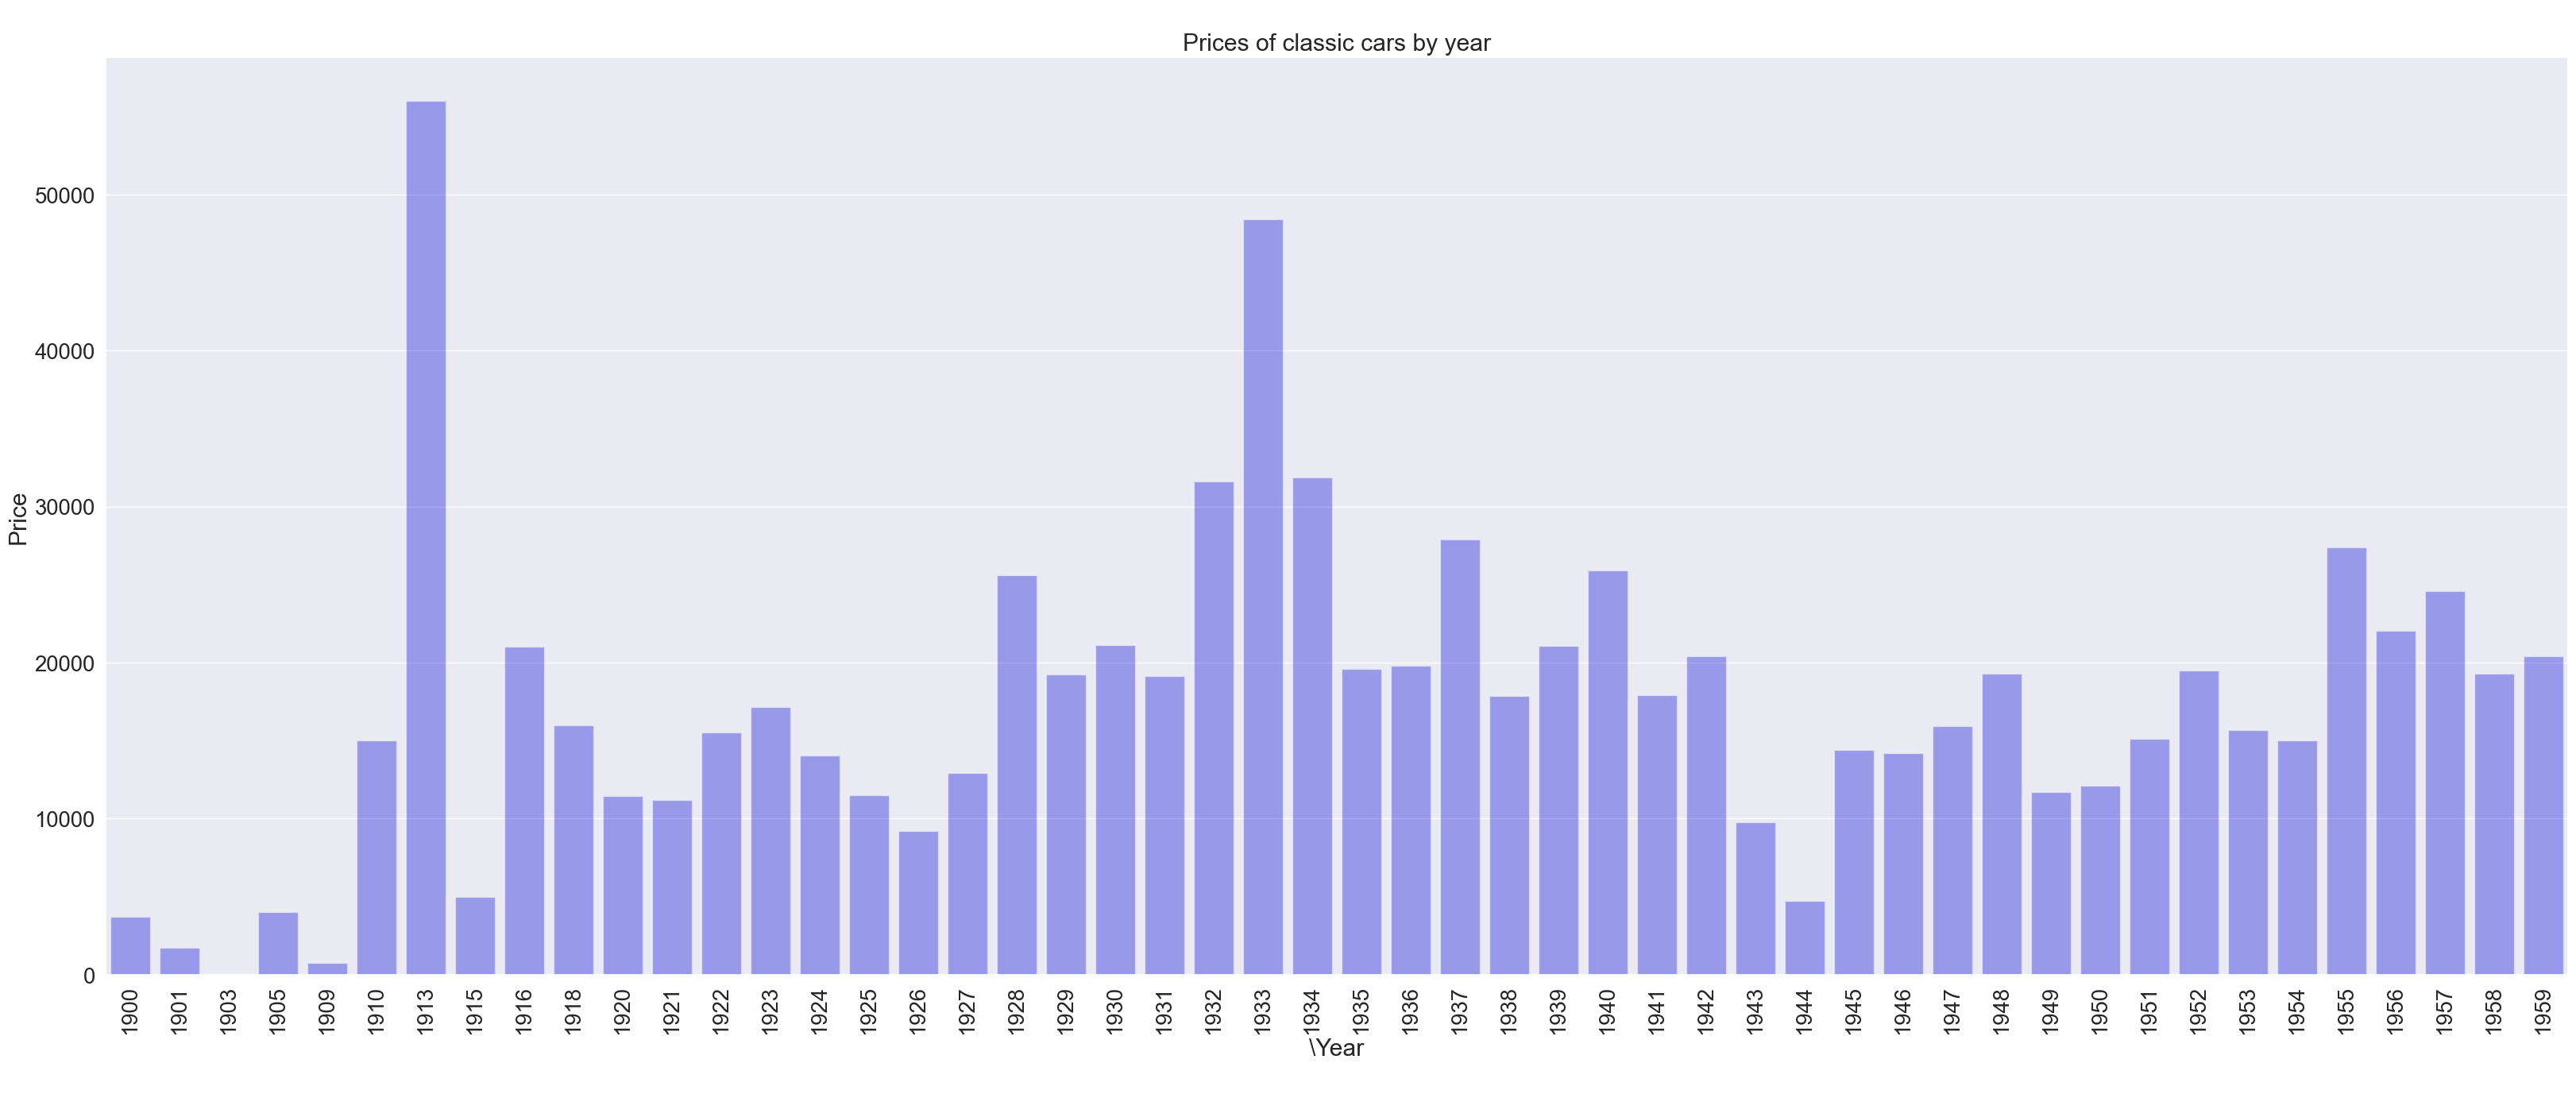

In [67]:
# Lets examine the classic cars 
classic_df['year'] = classic_df.year.astype('int')
cdata = classic_df.groupby(['type','manufacturer', 'year'])['price'].mean().sort_values(ascending=False).to_frame()

sns.set(style="darkgrid",font_scale=1.8)

fig, axs = plt.subplots(figsize=(40, 15))
g = sns.barplot(x = classic_df.year, y=classic_df.price, ci=None, alpha=0.4, color='blue')
plt.xticks(rotation=90) 
g.set_title('\nPrices of classic cars by year')
g.set_xlabel("\Year\n")
g.set_ylabel("Price")
plt.savefig('images/bar_year_price_classic_cars1.png')

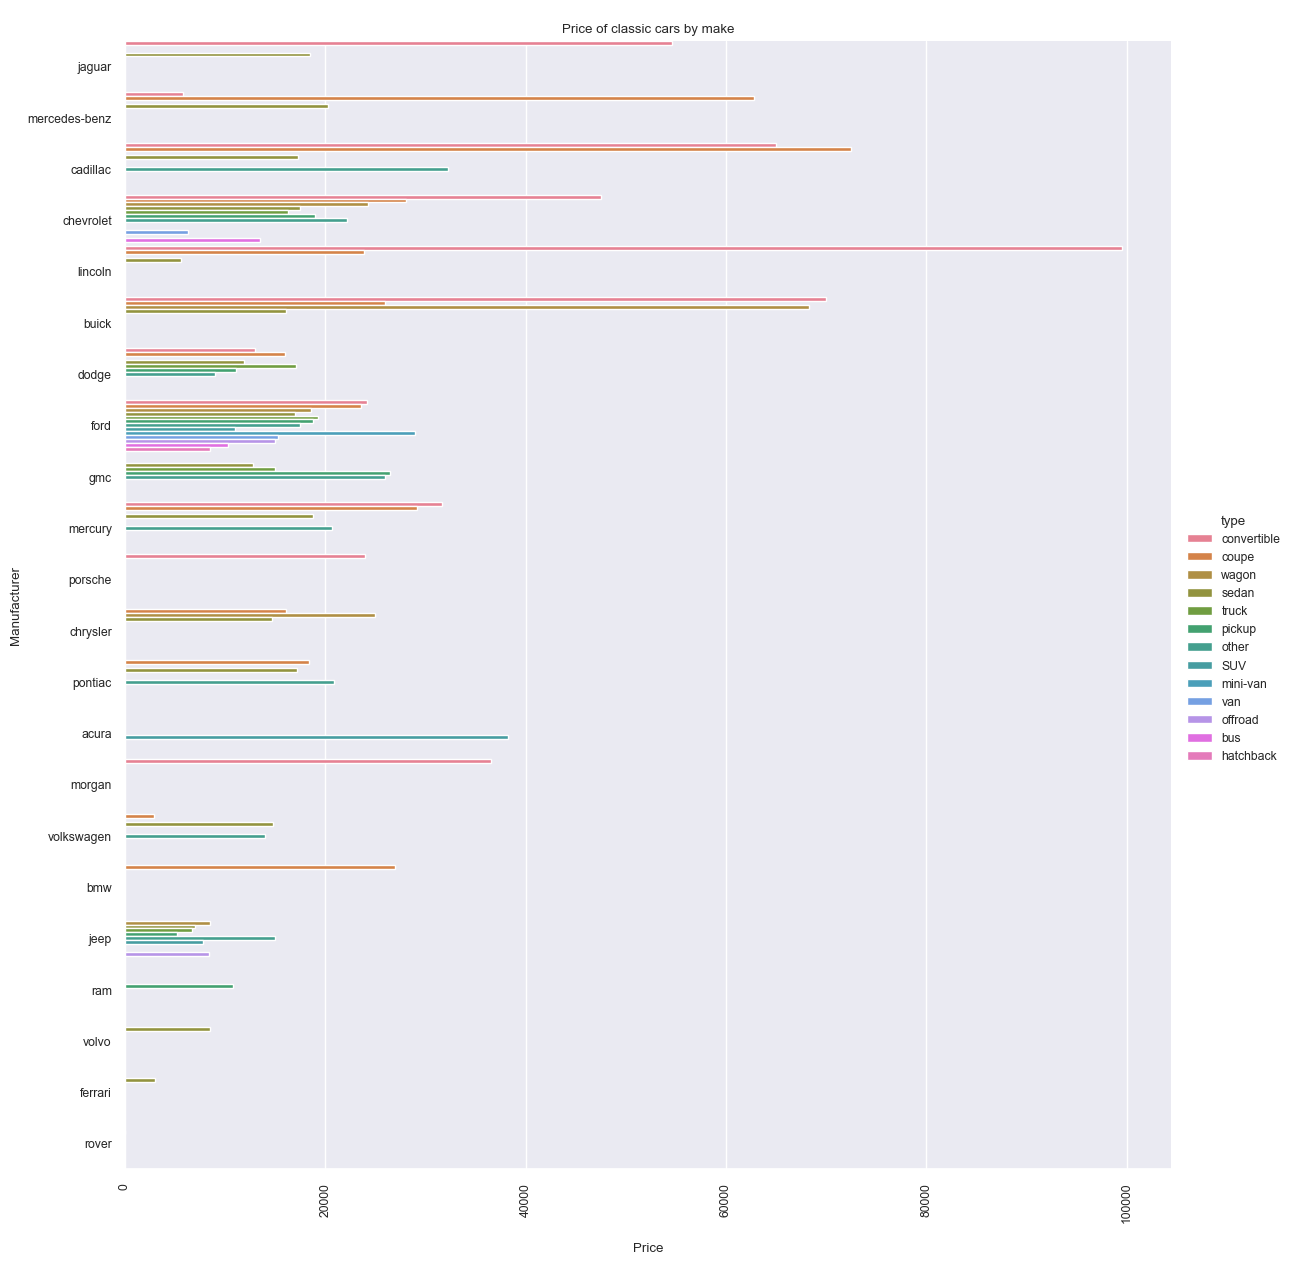

In [25]:
# Lets examine the classic cars 
cdata = classic_df.groupby(['type','manufacturer', 'year'])['price'].mean().sort_values(ascending=False).to_frame()
sns.set(style="darkgrid",font_scale=0.8)
g = sns.catplot(x='price', y='manufacturer', data=cdata, hue='type', kind='bar',width=1, \
                 height=12, ci=None)
ax = g.axes[0, 0]
plt.xticks(rotation=90) 
ax.set_title('\nPrice of classic cars by make')
ax.set_xlabel("\nPrice\n")
ax.set_ylabel("Manufacturer")
plt.savefig('images/bar_make_price_classic_cars2.png')

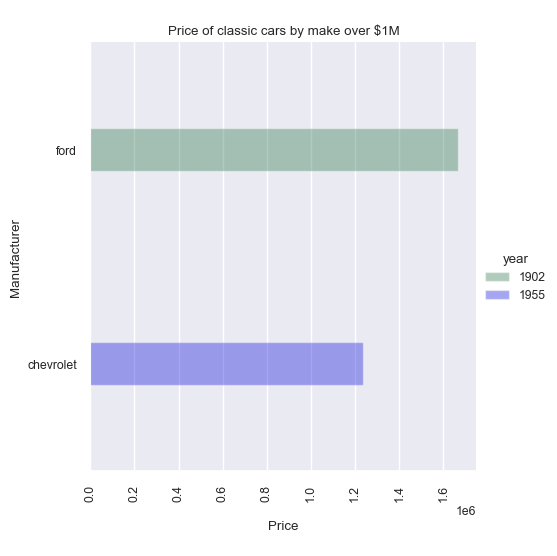

In [68]:
# Lets examine the expensive classic cars 
expensive_classic_df['year'] = expensive_classic_df.year.astype('int')
cdata = expensive_classic_df.groupby(['type','manufacturer', 'year'])['price'].mean().sort_values(ascending=False).to_frame()

sns.set(style="darkgrid",font_scale=0.8)
g = sns.catplot(x='price', y='manufacturer', data=cdata, palette=['seagreen','blue'], alpha=0.4,hue='year', width=0.2,kind='bar', \
                 height=5, ci=None)
ax = g.axes[0, 0]
plt.xticks(rotation=90) 
ax.set_title('\nPrice of classic cars by make over $1M')
ax.set_xlabel("\nPrice\n")
ax.set_ylabel("Manufacturer")
plt.savefig('images/bar_make_price_expensive_classic_cars3.png')

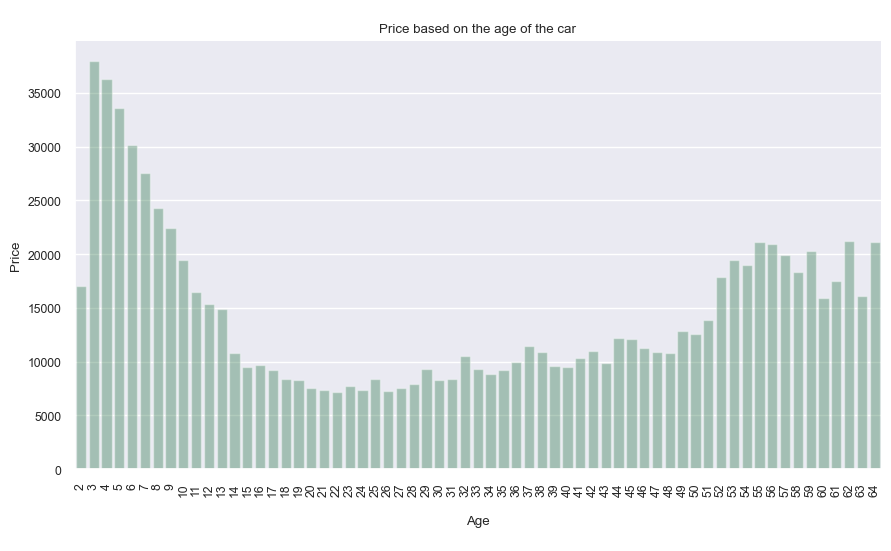

In [69]:
# Lets examine price against the age of the car
sns.set(style="darkgrid",font_scale=0.8)
g = sns.catplot(x='age', y='price', data=data, kind='bar', alpha = 0.4,\
                 height=5, aspect=1.8, palette=["seagreen"], ci=None)
plt.xticks(rotation=90) 
ax = g.axes[0, 0]
ax.set_title('\nPrice based on the age of the car')
ax.set_xlabel("\nAge\n")
ax.set_ylabel("Price")
plt.savefig('images/hist_age_price4.png')

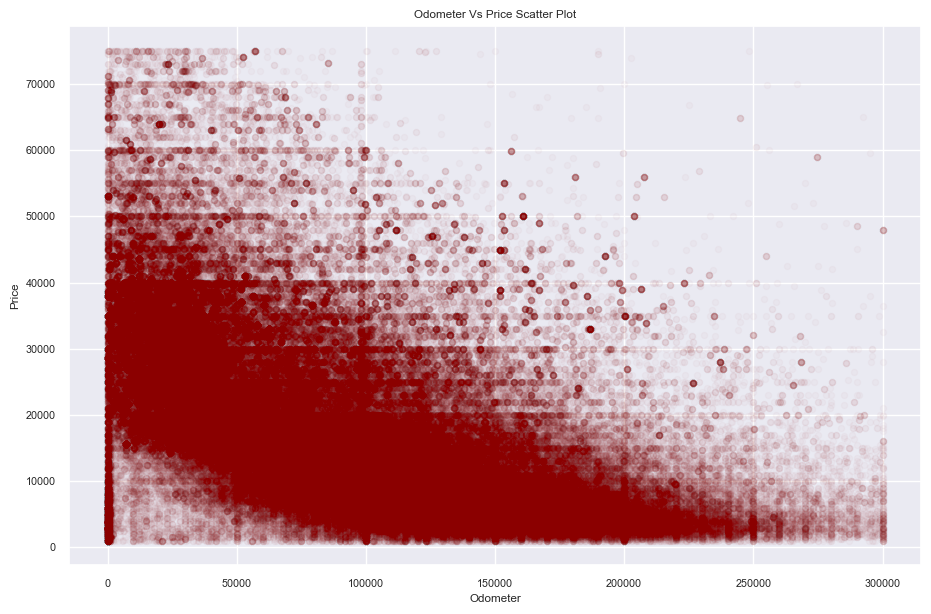

<Figure size 640x480 with 0 Axes>

In [28]:
# Lets examine Price against the Odometer
sns.set(style="darkgrid",font_scale=0.7)
fig, axs = plt.subplots(figsize=(11, 7))

data.plot(x='odometer',  
        y='price',  
        kind='scatter',  
        color='darkred',
        alpha=0.02,
        grid=True,  
        ax=axs)
plt.title('Odometer Vs Price Scatter Plot')
plt.xlabel('Odometer')
plt.ylabel('Price')
plt.show()
plt.savefig('images/scatter_odometer_price5.png')

In [71]:
# Lets examine the price based on categorical data

catlist = []
list(map(lambda col: catlist.append(data.groupby(col)['price'].mean().sort_values(ascending=False).to_frame()), \
            data.select_dtypes(include=['object']).columns));


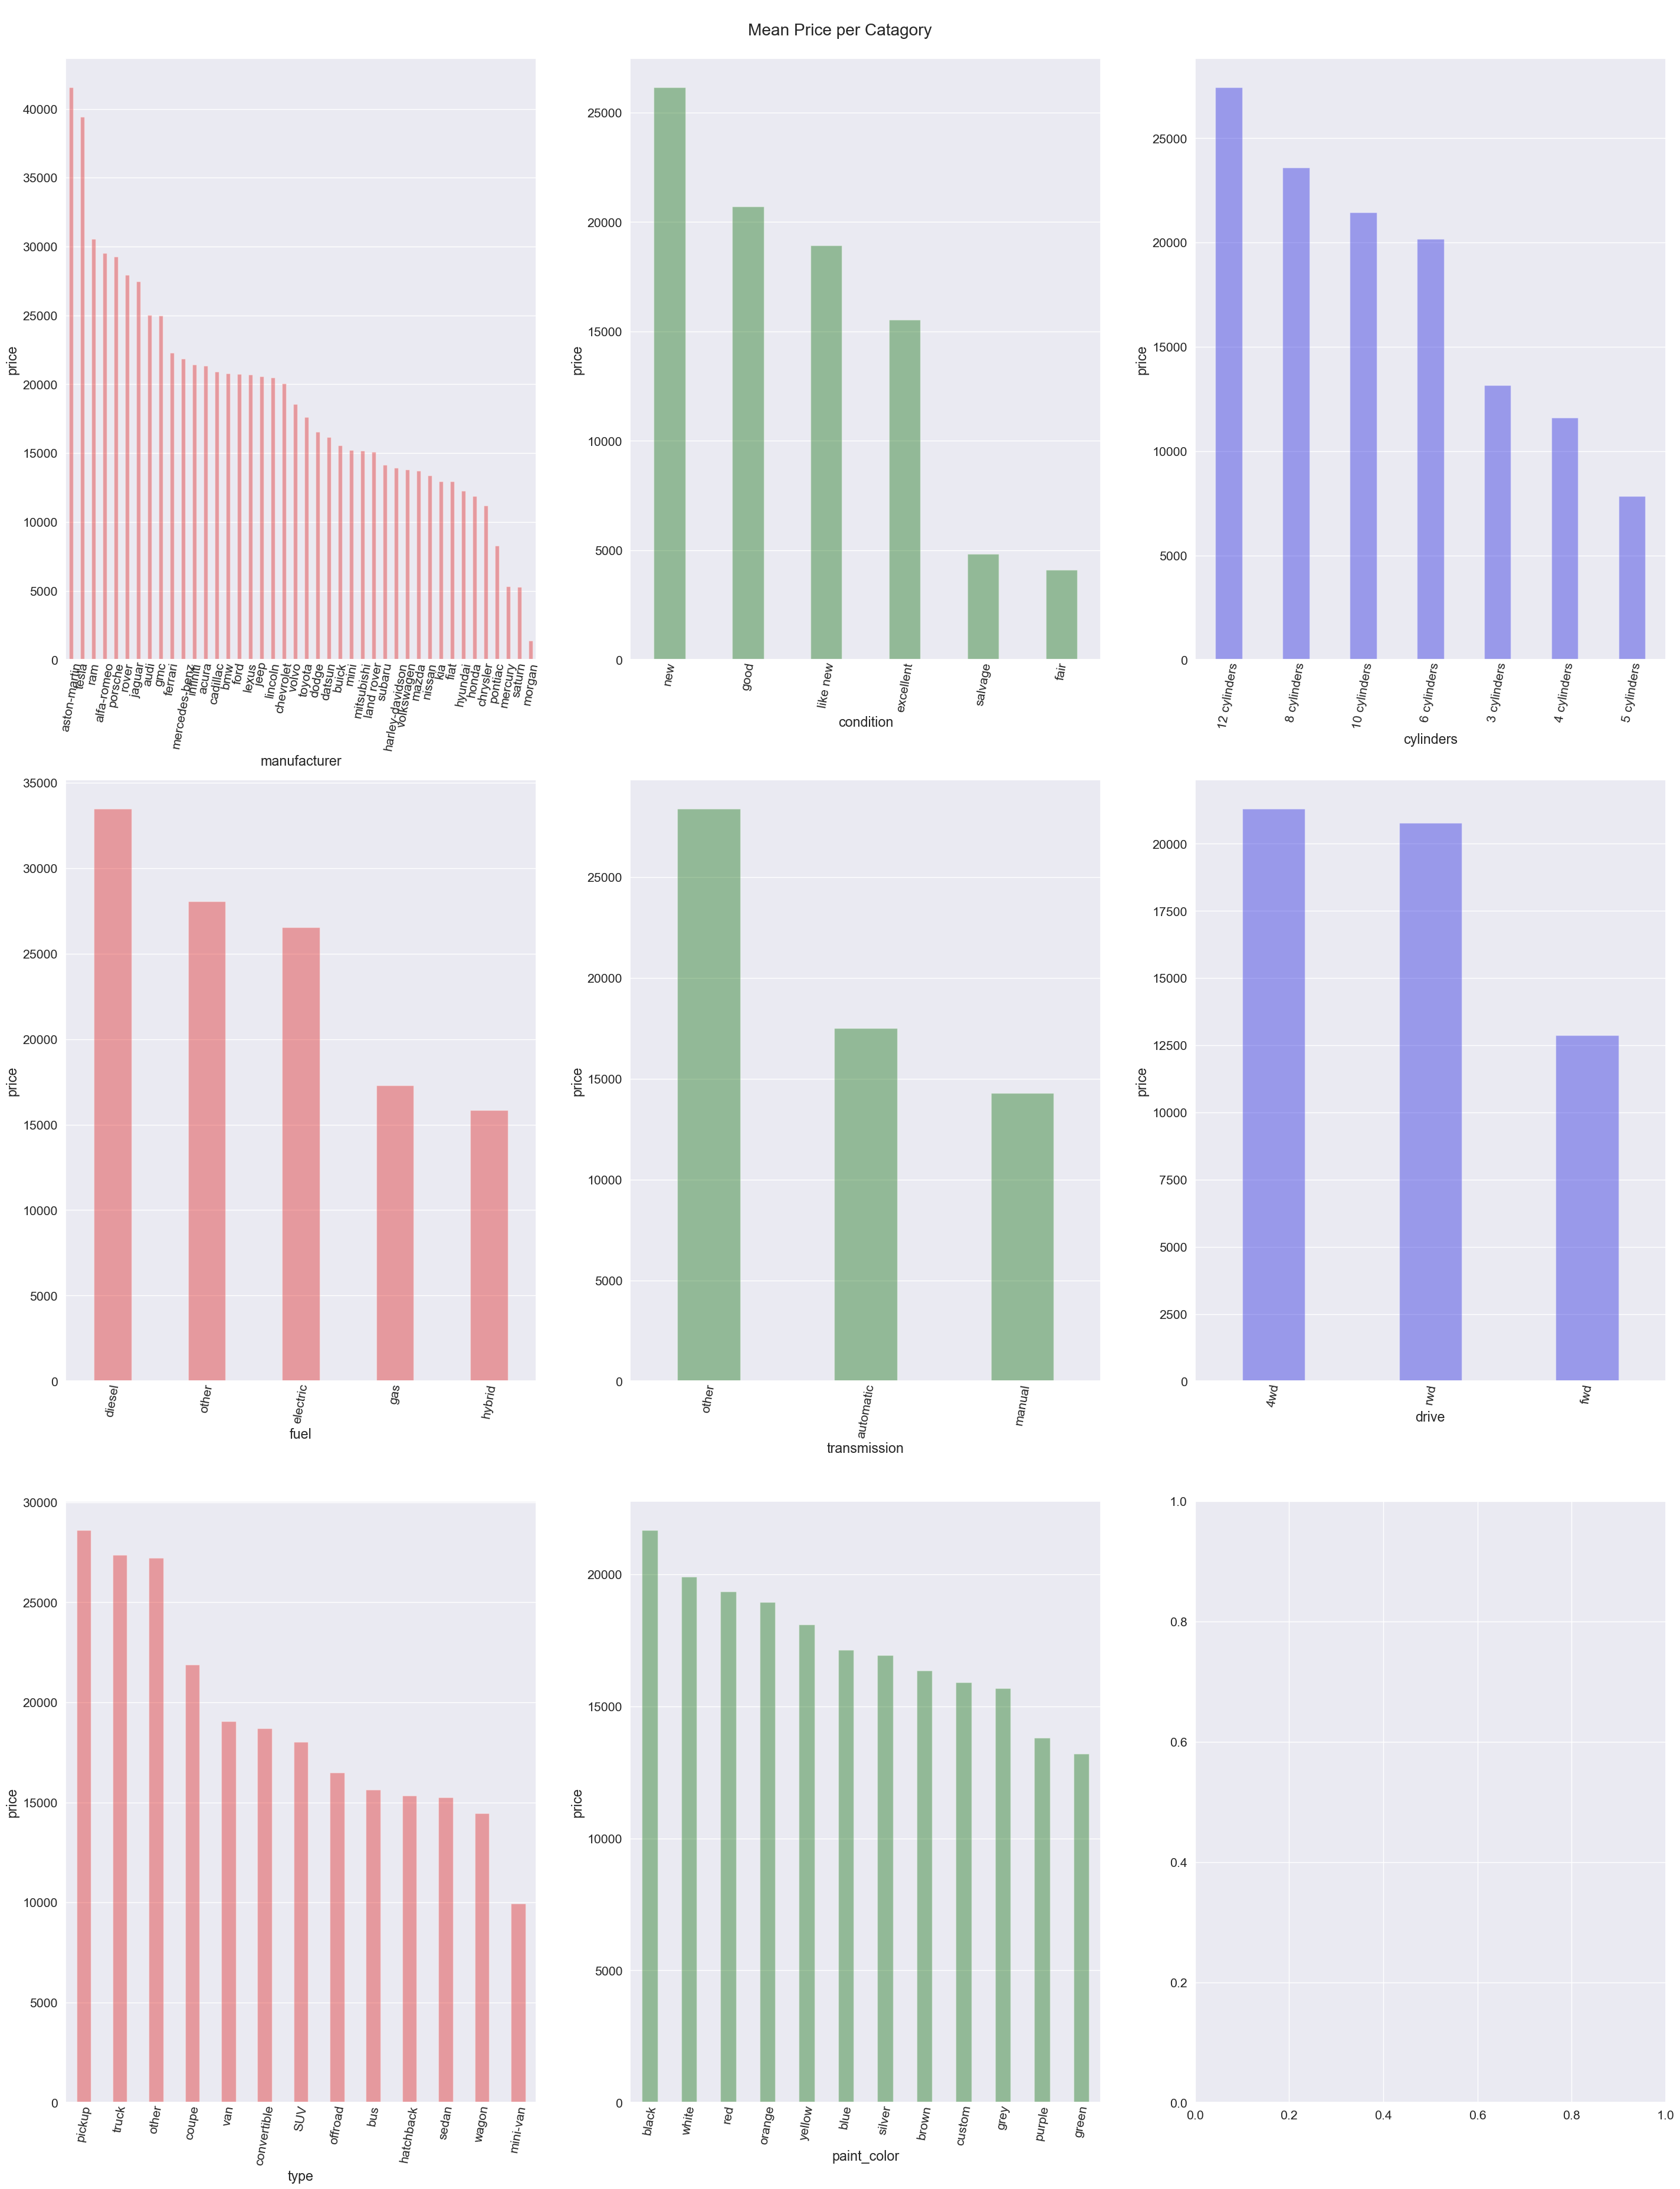

In [72]:
#Lets plot the categorical features against the price

fig, axs = plt.subplots(3, 3, figsize=(35, 45))
sns.set(style="darkgrid",font_scale=1.4)
fig.suptitle('\nMean Price per Catagory',x=0.5, y=0.9)
catfeaturelist = data.select_dtypes(include=['object']).columns
index = 0
i = 0
j = 0
color = "red"
for item in catlist:
    ax= sns.barplot(data=item, x=catfeaturelist[index], y='price', palette=[color], alpha=0.4, ax=axs[i,j], width=0.4)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=80, x=0.5, y=0.01)
    index = index + 1
    if j == 2:
        i = i + 1
    j = j + 1
    if j > 2:
        j = 0
    if color == "red" :
        color = "green"
    elif color == "green" :
        color = "blue"
    else:
        color = "red"
    
plt.savefig('images/catagory_price_mean6.png')
plt.show ()


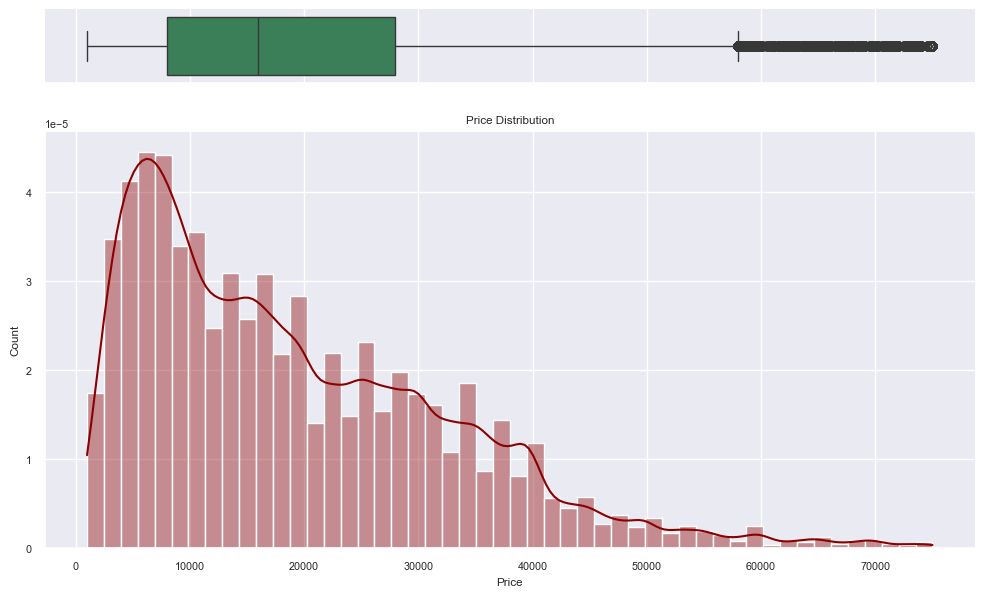

In [73]:
sns.set(style="darkgrid",font_scale=0.7)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12, 7))

sns.boxplot(data=data, x="price", color='seagreen', ax=ax_box)
sns.histplot(data=data, x="price", bins=50, color='darkred', alpha=0.4, kde=True, stat='density', ax=ax_hist)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.savefig('images/box_hist_price_dist7.png')

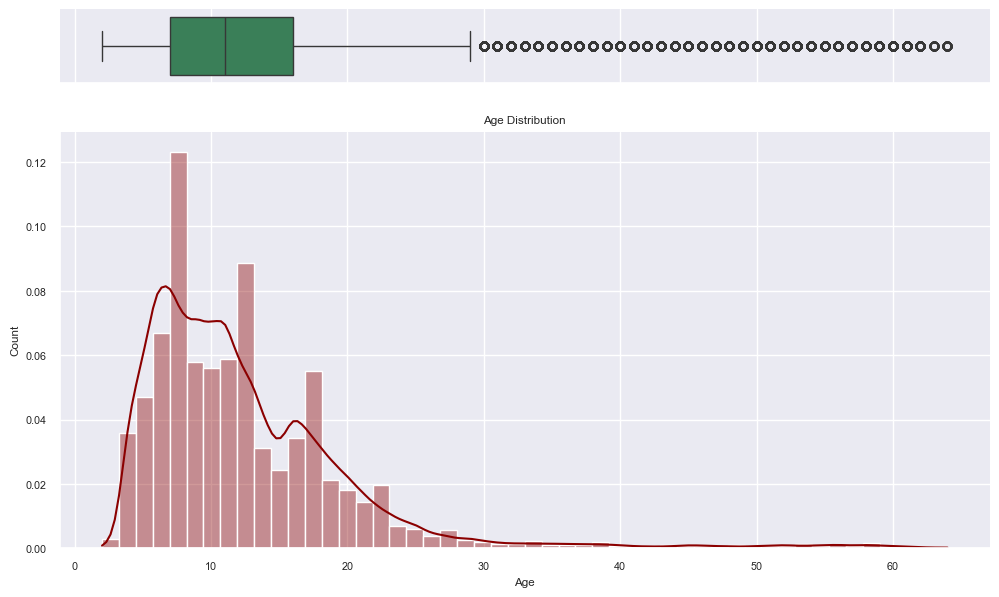

In [74]:

sns.set(style="darkgrid",font_scale=0.7)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12, 7))

sns.boxplot(data=data, x="age", color='seagreen', ax=ax_box)
sns.histplot(data=data, x="age", bins=50, color='darkred', alpha=0.4, kde=True, stat='density', ax=ax_hist)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.savefig('images/box_hist_age_dist8.png')

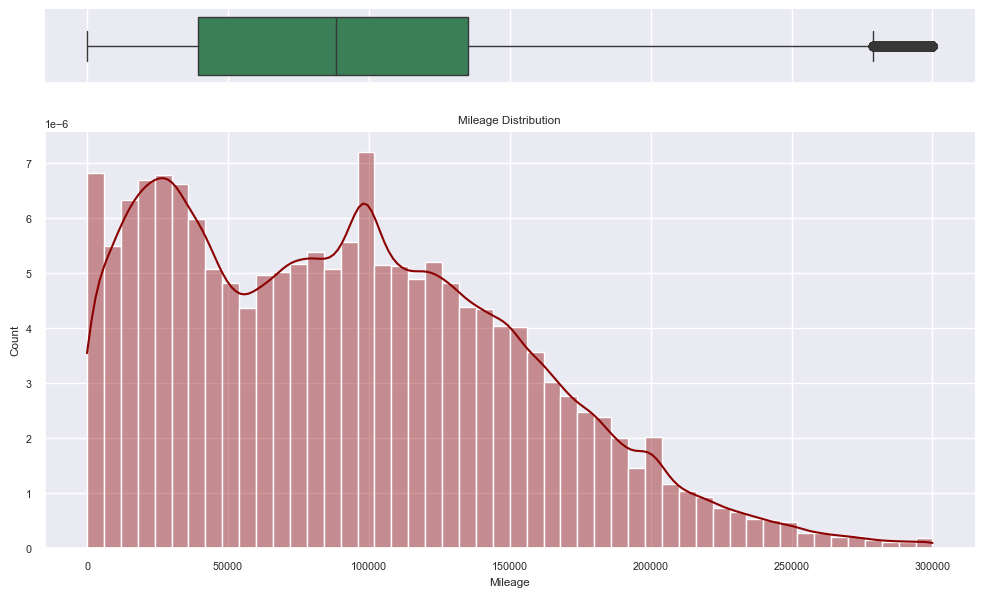

In [75]:
sns.set(style="darkgrid",font_scale=0.7)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12, 7))

sns.boxplot(data=data, x="odometer", color='seagreen', ax=ax_box)
sns.histplot(data=data, x="odometer", bins=50, color='darkred', alpha=0.4, kde=True, stat='density', ax=ax_hist)
plt.title('Mileage Distribution')
plt.xlabel('Mileage')
plt.ylabel('Count')

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.savefig('images/box_hist_odometer_dist9.png')

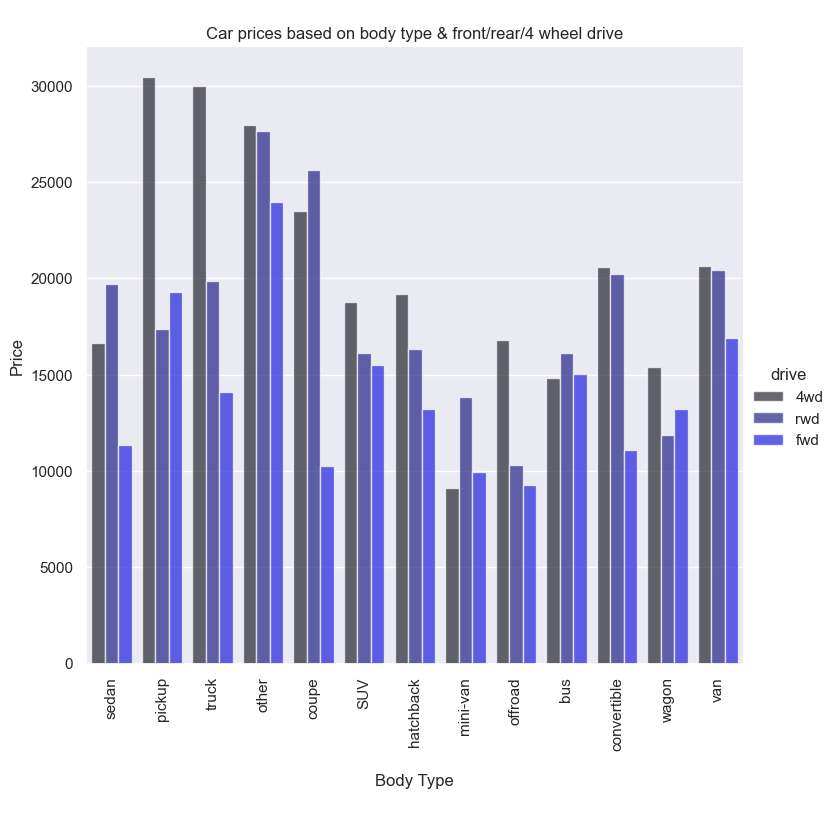

In [76]:
sns.set(style="darkgrid",font_scale=1.0)

g = sns.catplot(x='type', y='price', data=data, hue='drive',kind='bar', color='blue', alpha = 0.7,\
                 height=7, aspect=1.1, ci=None)
ax = g.axes[0, 0]
plt.xticks(rotation=90) 
ax.set_title('\nCar prices based on body type & front/rear/4 wheel drive')
ax.set_xlabel("\nBody Type\n")
ax.set_ylabel("Price")
plt.savefig('images/hist_price_typeDrive10.png')

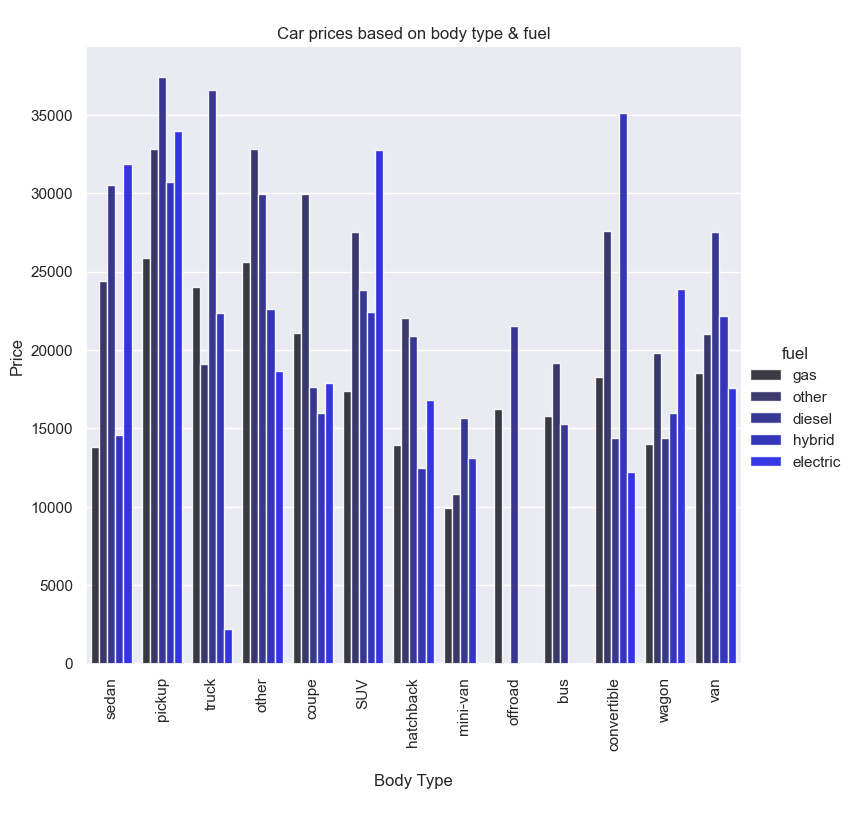

In [77]:
sns.set(style="darkgrid",font_scale=1.0)

g = sns.catplot(x='type', y='price', hue='fuel', data=data, kind='bar', \
                 height=7, aspect=1.1, color='blue', alpha = 0.9, ci=None)
ax = g.axes[0, 0]
plt.xticks(rotation=90) 
ax.set_title('\nCar prices based on body type & fuel')
ax.set_xlabel("\nBody Type\n")
ax.set_ylabel("Price")
plt.savefig('images/hist_price_typeFuel11.png')

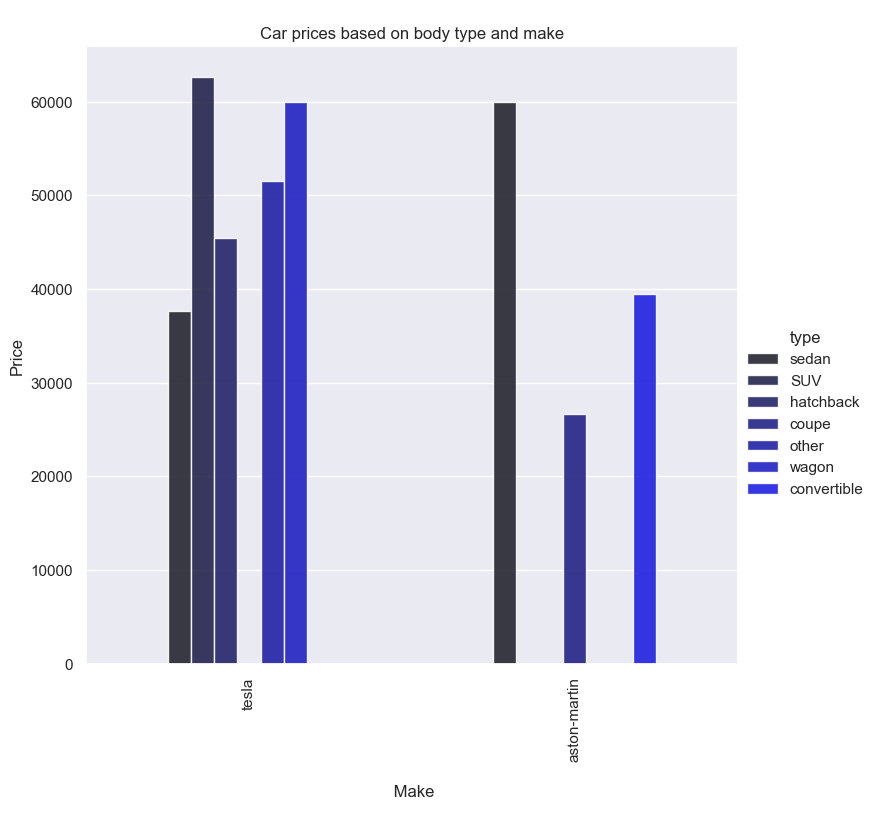

In [78]:
#Manufacturer with the most expensive cars
cdata = data[ ((data['manufacturer'] == "tesla") | (data['manufacturer'] == "aston-martin"))][['price', 'manufacturer', 'type', 'fuel']]
sns.set(style="darkgrid",font_scale=1.0)

g = sns.catplot(x='manufacturer', y='price', data=cdata, hue='type', color='blue', aspect=1.1, width=0.5, kind='bar', alpha=0.9, \
                 height=7, ci=None)
ax = g.axes[0, 0]
plt.xticks(rotation=90) 
ax.set_title('\nCar prices based on body type and make')
ax.set_xlabel("\n Make\n")
ax.set_ylabel("Price")
plt.savefig('images/hist_price_type_make12.png')

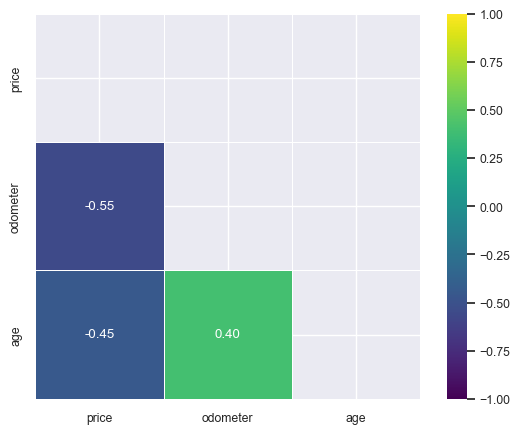

In [81]:
plt.figure(figsize = (7,5))
plt.rcParams.update({'font.size': 12})
numeric_corr = data[['price', 'odometer', 'age']].corr(numeric_only=True)
sns.set(style="darkgrid",font_scale=0.8)
mask = np.triu(np.ones_like(numeric_corr, dtype=bool))
sns.heatmap(numeric_corr, cmap = 'viridis', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5, mask = mask)
ax.set_title("Heatmap of numeric features")
plt.savefig('images/heatmap_numeric_features13.png')
plt.show()

 there is no multicollinearity between the features

### Pre-processing

In [82]:
#Catagorical features transformation

#Ordinal encoder
dict = {'clean':5, 'rebuilt':4, 'lien':6, 'salvage':3, 'missing':2, 'parts only':1}
data.replace({'title_status':dict},inplace=True);
data.title_status.unique()




array([5, 4, 6, 3, 2, 1])

In [45]:
#Encoding Categorical Features
categorical_cols = data.select_dtypes(include = 'object').columns


preprocessor = ColumnTransformer(
    transformers = [
         ('num', StandardScaler(), ['age','odometer', 'title_status']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['age', 'odometer', 'title_status']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['manufacturer', 'condition', 'cylinders', 'fuel', 'transmission',
       'drive', 'type', 'paint_color'],
      dtype='object'))])

####   At this point we are done preparing the data for run it through the model.

## Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [46]:
# Lets split the data into taining and test
df = data
test_size = 0.3
random_state = 42
X = df.drop(['price'], axis=1) 
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
print( "X_train shape = " + str(X_train.shape) + "\n X_test shape = " + str(X_test.shape))
print( "y_train shape = " + str(y_train.shape) + "\n y_test shape = " + str(y_test.shape))
X_train.head()

X_train shape = (260831, 11)
 X_test shape = (111785, 11)
y_train shape = (260831,)
 y_test shape = (111785,)


,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,age
315873,buick,good,6 cylinders,gas,148526.0,5,automatic,fwd,sedan,purple,27
77515,bmw,good,6 cylinders,gas,63299.0,5,automatic,4wd,sedan,white,8
187816,lexus,good,6 cylinders,gas,163027.0,5,automatic,4wd,sedan,white,16
39047,lexus,good,6 cylinders,gas,51558.0,5,automatic,fwd,hatchback,black,9
255100,nissan,good,6 cylinders,gas,87868.0,5,automatic,fwd,van,white,7



    Degrees  Training_MSE      Test_MSE
0         1  7.297669e+07  7.349757e+07
1         2  1.309253e+08  1.310163e+08
2         3  1.457291e+08  1.461601e+08
3         4  1.592814e+08  1.599087e+08
4         5  1.690482e+08  1.697570e+08
5         6  1.303530e+08  1.332919e+08
6         7  1.401456e+08  1.426583e+08
7         8  1.490516e+08  1.543309e+08
8         9  3.092965e+08  3.368361e+08
9        10  1.687534e+08  1.757941e+08
10       11  2.116563e+08  2.119087e+08
11       12  1.750740e+08  1.815701e+08
12       13  1.806477e+08  1.856502e+08
13       14  2.122164e+08  2.441789e+08
14       15  2.014683e+08  2.049210e+08
15       16  3.125472e+08  3.619841e+08
16       17  2.161025e+08  2.171594e+08
17       18  2.190979e+08  3.392847e+08
18       19  2.023961e+08  2.052539e+08
19       20  1.969354e+08  2.151005e+08

    Degrees  Training_RMSE     Test_RMSE
0         1    8542.639274   8573.072101
1         2   11442.260201  11446.233720
2         3   12071.831879  12089.6

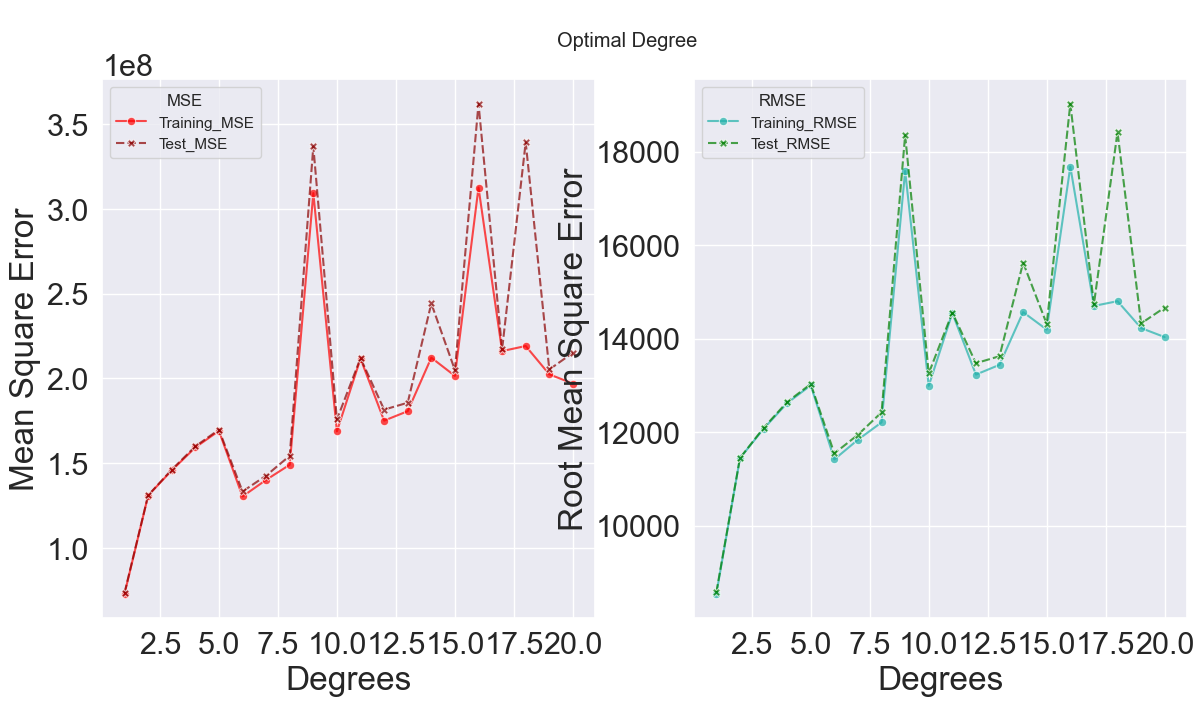

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=20),
                                                  ['age', 'odometer']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'odometer',
                                                   'title_status']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['manufacturer', 'condition', 'cylinders', 'fuel', 'transmission',
       'drive', 'type', 'paint_color'],
      dtype='object'))])),
                ('model', LinearRegression())])

In [89]:
#Lets define pipeline with a pre-processor and a polynomial linear regression model to find the best degree

train_mses = [] 
test_mses = []
train_rmses = [] 
test_rmses = []
degrees = np.arange(1, 21)
for i in degrees:
    poly_preprocessor = ColumnTransformer( 
        transformers=[
            ('polynomialfeatures', PolynomialFeatures(degree = i), ['age','odometer']),
            ('num', StandardScaler(), ['age','odometer','title_status']),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])

    pipe = Pipeline(steps=[ 
        ('preprocessor', poly_preprocessor), 
        ('model', LinearRegression())
    ])
    pipe.fit(X_train, y_train)
    #fit on train
    p1 = pipe.predict(X_train)
    p2 = pipe.predict(X_test)
    #predict on train and test 
    train_mses.append(mean_squared_error(y_train, p1)) 
    test_mses.append(mean_squared_error(y_test, p2))
    train_rmses.append(root_mean_squared_error(y_train, p1)) 
    test_rmses.append(root_mean_squared_error(y_test, p2))

df_degrees_mse = pd.DataFrame({'Degrees':degrees, 'Training_MSE':train_mses, 'Test_MSE':test_mses})
df_degrees_rmse = pd.DataFrame({'Degrees':degrees, 'Training_RMSE':train_rmses, 'Test_RMSE':test_rmses})
print("\n" + str(df_degrees_mse) + "\n\n" + str(df_degrees_rmse))

mse_dfm = df_degrees_mse.melt('Degrees', var_name='MSE', value_name='Mean Square Error')
rmse_dfm = df_degrees_rmse.melt('Degrees', var_name='RMSE', value_name='Root Mean Square Error')

#Lets plot the MSE Vs hyperparameter 'Degree' for train and test data sets
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
sns.set(style="darkgrid",font_scale=1.0)
fig.suptitle('\nOptimal Degree')
ax = sns.lineplot(data = mse_dfm, x='Degrees', y='Mean Square Error', palette=["red", "darkred"], alpha=0.7,\
                  hue='MSE', legend=True, style="MSE", markers=True, dashes=True, ax=axs[0])
ax = sns.lineplot(data = rmse_dfm, x='Degrees', y='Root Mean Square Error', palette=["lightseagreen", "green"], alpha=0.7,\
                  hue='RMSE', legend=True, style="RMSE", markers=True, dashes=True, ax=axs[1])
plt.savefig('images/polynomialDegree14.png')
plt.show ()


pipe


In [48]:
#Best degree polynomial model
best_complexity = test_mses.index(min(test_mses)) + 1
best_mse = min(test_mses)
print(f'The best degree polynomial model is: {best_complexity}')
print(f'The smallest mean squared error on the test data is : {best_mse: .2f}')

The best degree polynomial model is: 1
The smallest mean squared error on the test data is :  73497565.26


In [83]:
#preprocessor for modeling
model_preprocessor = ColumnTransformer( 
        transformers=[
            ('num', StandardScaler(), ['age','odometer','title_status']),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])



In [84]:
#Linear Req
linear_pipe = Pipeline(steps=[ 
        ('preprocessor', model_preprocessor), 
        ('model', LinearRegression())
    ])
linear_pipe.fit(X_train,y_train)
p1 = linear_pipe.predict(X_train)
p2 = linear_pipe.predict(X_test)
#predict on train and test 
lr_train_mses = mean_squared_error(y_train, p1)
lr_test_mses = mean_squared_error(y_test, p2)
lr_train_rmses = root_mean_squared_error(y_train, p1) 
lr_test_rmses = root_mean_squared_error(y_test, p2)

print(f'MSE for Linear Regression Train Data: {lr_train_mses}')
print(f'MSE for Linear Regression Test Data: {lr_test_mses}')
print(f'RMSE for Linear Regression Train Data: {lr_train_rmses}')
print(f'RMSE for Linear Regression Test Data: {lr_test_rmses}')

MSE for Linear Regression Train Data: 66991589.54994979
MSE for Linear Regression Test Data: 67670622.73403727
RMSE for Linear Regression Train Data: 8184.839005744083
RMSE for Linear Regression Test Data: 8226.215577897121


In [53]:
#Ridge model uisng GridSearch 
ridge_pipe = Pipeline(steps=[ 
        ('preprocessor', model_preprocessor), 
        ('ridge', Ridge())
    ])

ridge_param_dict = {'ridge__alpha': [1,1.1,1.2,1.5,2,3,5,10]}
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict)
ridge_grid.fit(X_train, y_train)
ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)
ridge_train_rmse = root_mean_squared_error(y_train, ridge_train_preds)
ridge_test_rmse = root_mean_squared_error(y_test, ridge_test_preds)

print(f'Train MSE: {ridge_train_mse}') 
print(f'Test MSE: {ridge_test_mse}')
print(f'Train RMSE: {ridge_train_rmse}') 
print(f'Test RMSE: {ridge_test_rmse}')
print(f"Optimal alpha using Ridge: {ridge_grid.best_params_}")

Train MSE: 66994485.86807537
Test MSE: 67674782.17623647
Train RMSE: 8185.015935725194
Test RMSE: 8226.468390277596
Optimal alpha using Ridge: {'ridge__alpha': 1.5}


In [55]:
#Lasso model uisng GridSearch 
# 
lasso_pipe = Pipeline(steps=[ 
        ('preprocessor', model_preprocessor), 
        ('lasso', Lasso())
    ])
lasso_param_dict = {'lasso__alpha': [.1,.2,.5,.7,1,1.1]}
lasso_grid = GridSearchCV(lasso_pipe, param_grid=lasso_param_dict)
lasso_grid.fit(X_train, y_train)
lasso_train_preds = lasso_grid.predict(X_train)
lasso_test_preds = lasso_grid.predict(X_test)
lasso_train_mse = mean_squared_error(y_train, lasso_train_preds)
lasso_test_mse = mean_squared_error(y_test, lasso_test_preds)
lasso_train_rmse = root_mean_squared_error(y_train, lasso_train_preds)
lasso_test_rmse = root_mean_squared_error(y_test, lasso_test_preds)

print(f'Train MSE: {lasso_train_mse}') 
print(f'Test MSE: {lasso_test_mse}')
print(f'Train RMSE: {lasso_train_rmse}') 
print(f'Test RMSE: {lasso_test_rmse}')
print(f"Optimal alpha using Lasso: {lasso_grid.best_params_}")

Train MSE: 66995774.68803831
Test MSE: 67675799.25908662
Train RMSE: 8185.094665795767
Test RMSE: 8226.53020775385
Optimal alpha using Lasso: {'lasso__alpha': 0.2}


In [57]:
# Linear Regression provided the best results. Lets examine the best features. 

results = permutation_importance(poly_pipe, X_train, y_train,n_repeats=30,random_state=1)
important_features = results.importances_mean
important_features

array([0.05644912, 0.00392908, 0.03717845, 0.13545467, 0.40892553,
       0.00648698, 0.00356544, 0.02570382, 0.05883016, 0.00156463,
       0.17567467])

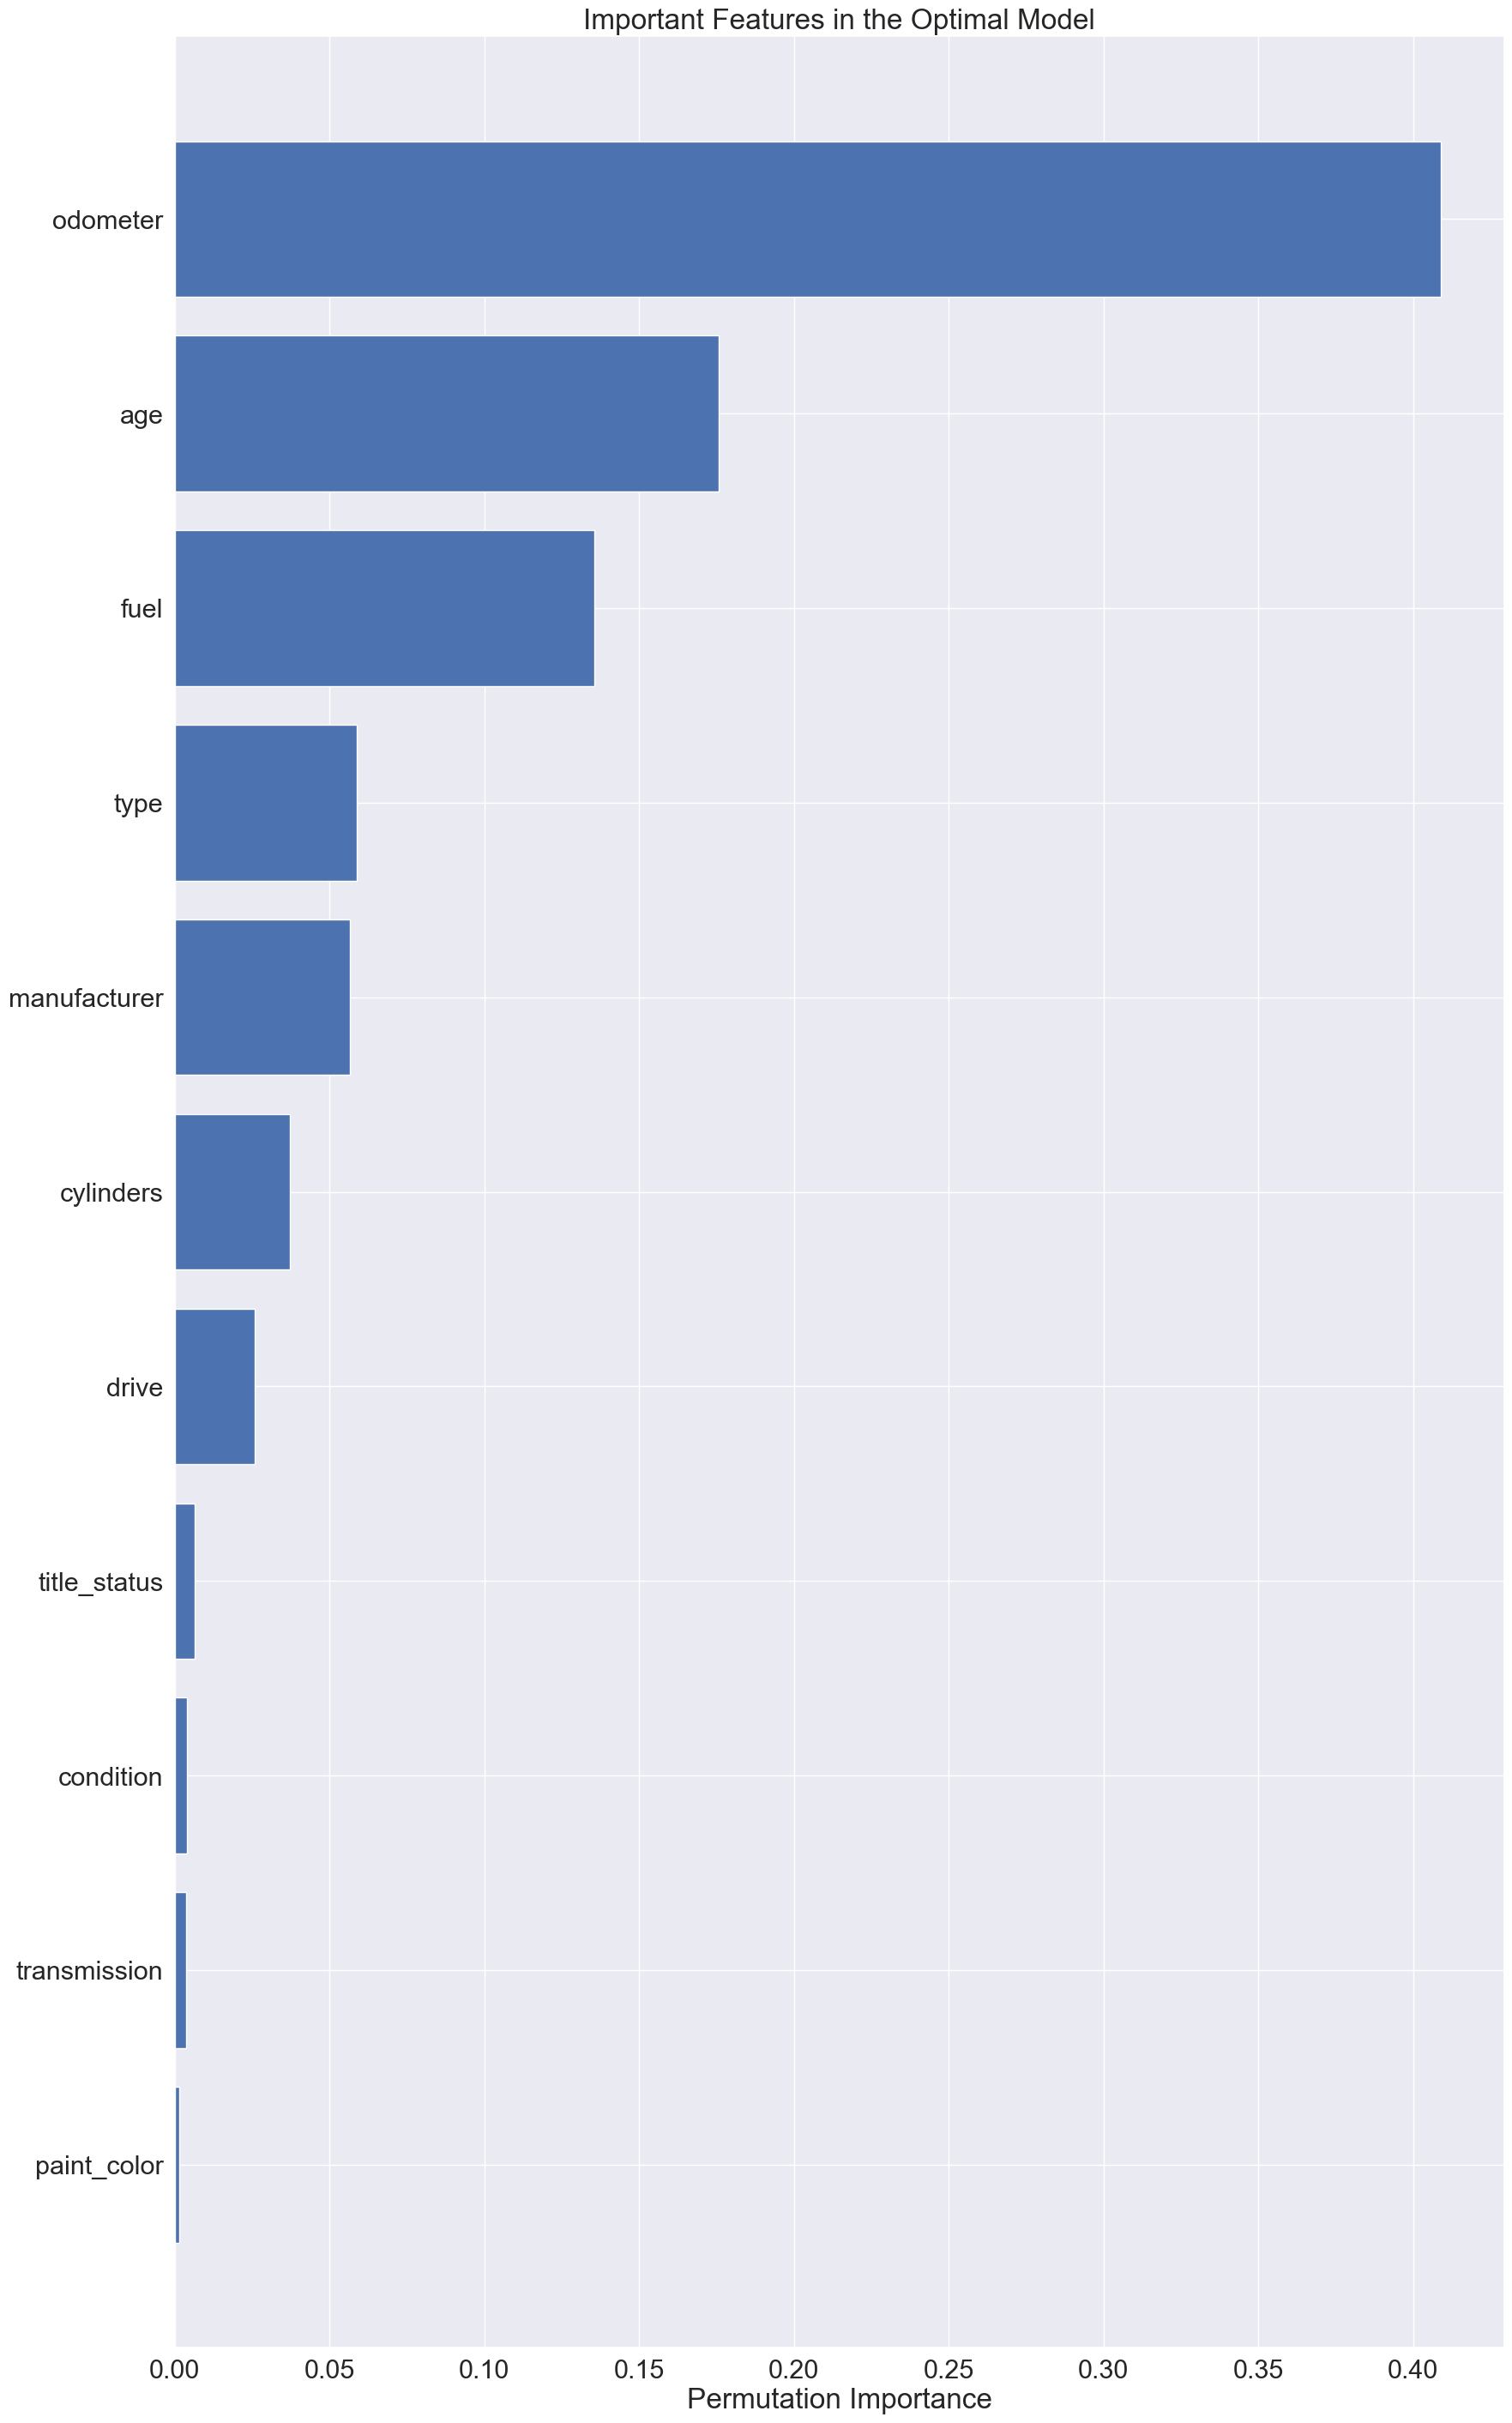

In [88]:
#Map the coefficients back to the features
sorted_idx = np.argsort(important_features)
sns.set(style="darkgrid",font_scale=2)
fig, axs = plt.subplots(figsize=(20, 35))
plt.barh(range(len(sorted_idx)), important_features[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_test.columns[sorted_idx]);
plt.xlabel('Permutation Importance', )
plt.title('Important Features in the Optimal Model')
plt.savefig('images/importantFeatures15.png')
plt.show()
